# Fundamentos de analítica 2 (clase 1)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com


## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (TD_13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(220, 4)


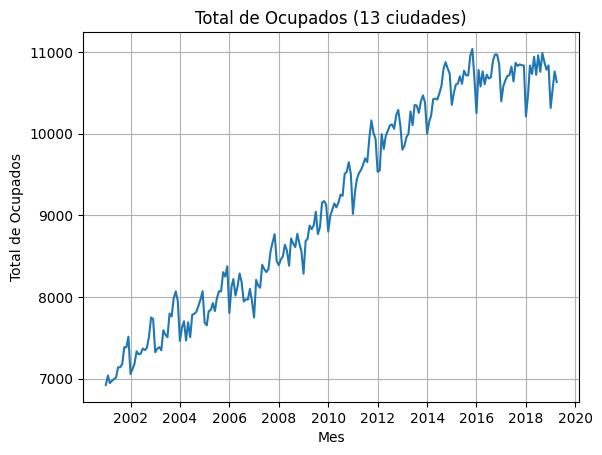

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Total de Ocupados (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Total de Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose. 

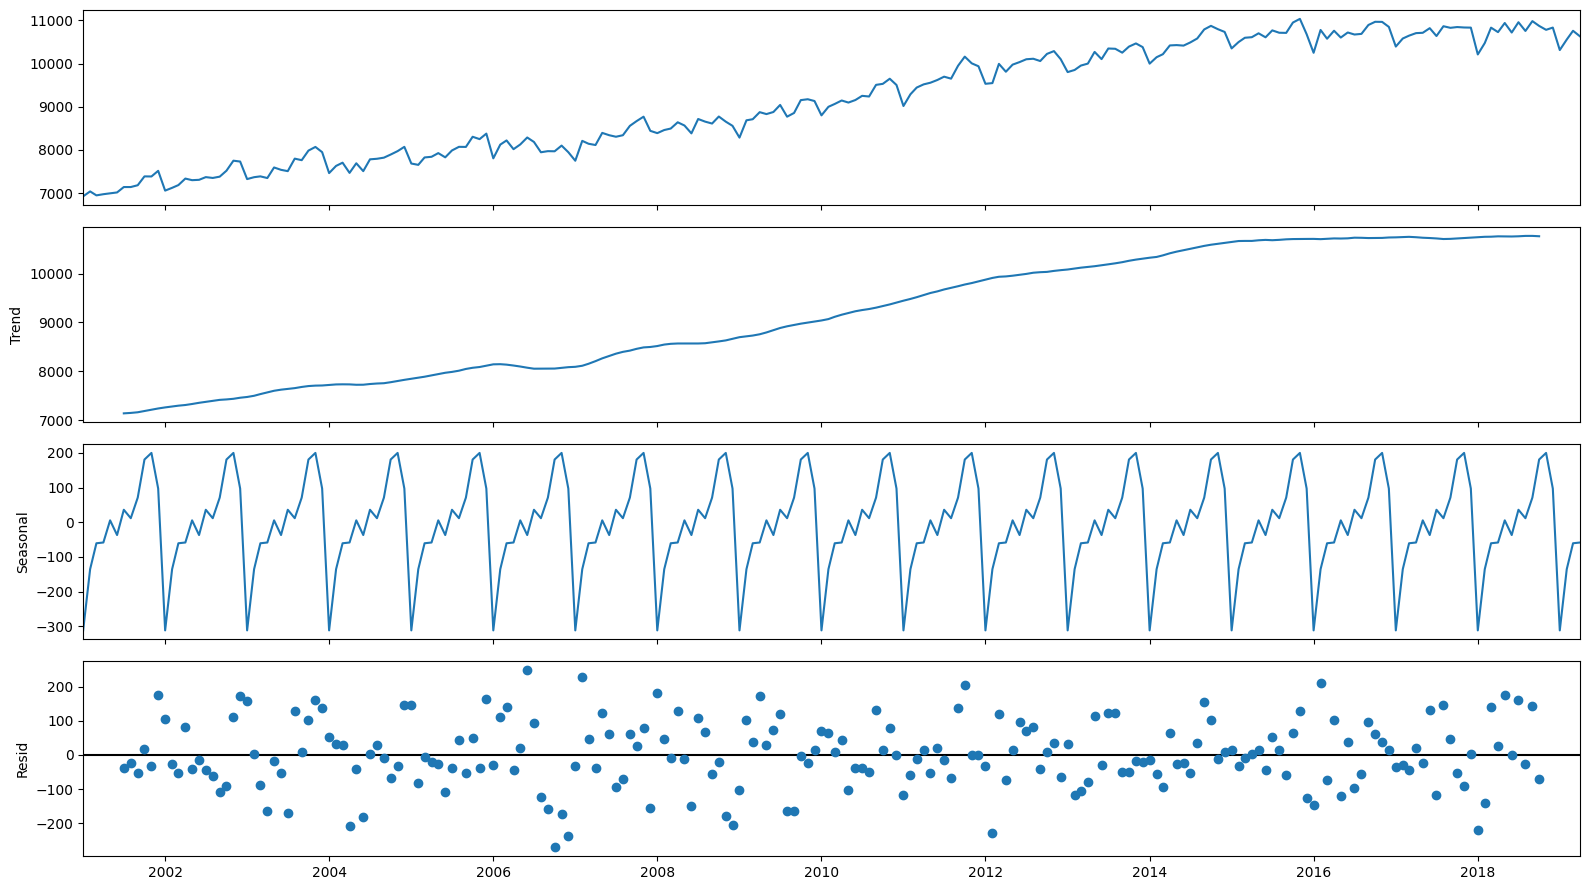

In [4]:
Ocupados_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = Ocupados_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
Ocupados_componentes.seasonal


mes
2001-01-01   -311.454885
2001-02-01   -135.216366
2001-03-01    -60.470657
2001-04-01    -58.270721
2001-05-01      5.551095
                 ...    
2018-12-01     97.140345
2019-01-01   -311.454885
2019-02-01   -135.216366
2019-03-01    -60.470657
2019-04-01    -58.270721
Name: seasonal, Length: 220, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

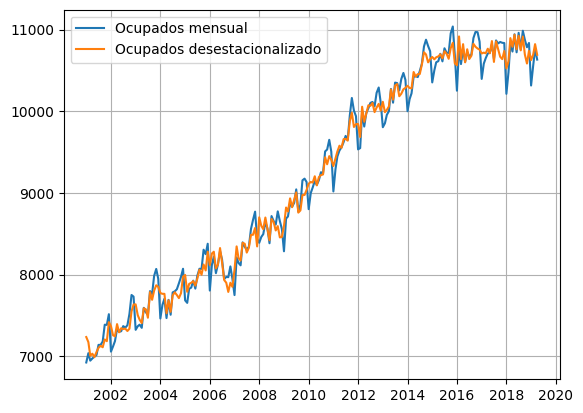

In [6]:
Ocupados_desestacionalizada = data["Ocupados"]-Ocupados_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(Ocupados_desestacionalizada,label="Ocupados desestacionalizado")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos. 

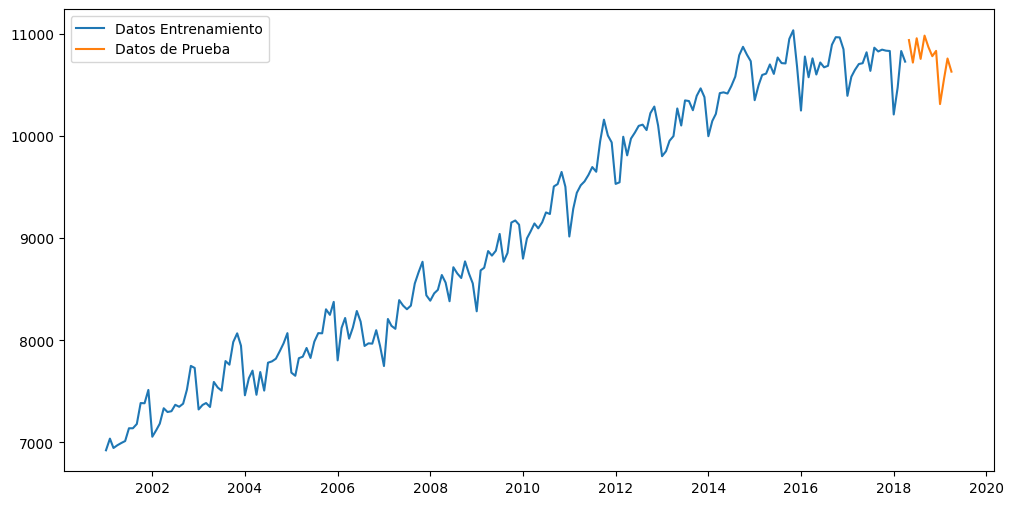

In [7]:
train_len = 208
train_Ocupados = data[["Ocupados"]][:train_len]
test_Ocupados = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(test_Ocupados,label="Datos de Prueba")
plt.legend()
plt.show()

In [8]:
train_Ocupados

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-12-01,10834.330
2018-01-01,10212.612
2018-02-01,10476.311


In [9]:
test_Ocupados

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [10]:
## Considerando el dato actual
ma_2= train_Ocupados.rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.rolling(5,min_periods=2).mean()

In [11]:
## Sin considerar el dato actual
ma_2= train_Ocupados.shift().rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.shift().rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.shift().rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.shift().rolling(5,min_periods=2).mean()


In [12]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:] 

In [13]:
ma_2_f= fore_ma(train_Ocupados,2,12)
ma_3_f= fore_ma(train_Ocupados,3,12)
ma_4_f= fore_ma(train_Ocupados,4,12)
ma_5_f= fore_ma(train_Ocupados,5,12)

In [14]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_Ocupados,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_Ocupados,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_Ocupados,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_Ocupados,ma_5_f ))

In [15]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

180.61405651284463 190.8075001193029 218.76010738130725 221.86244433696749


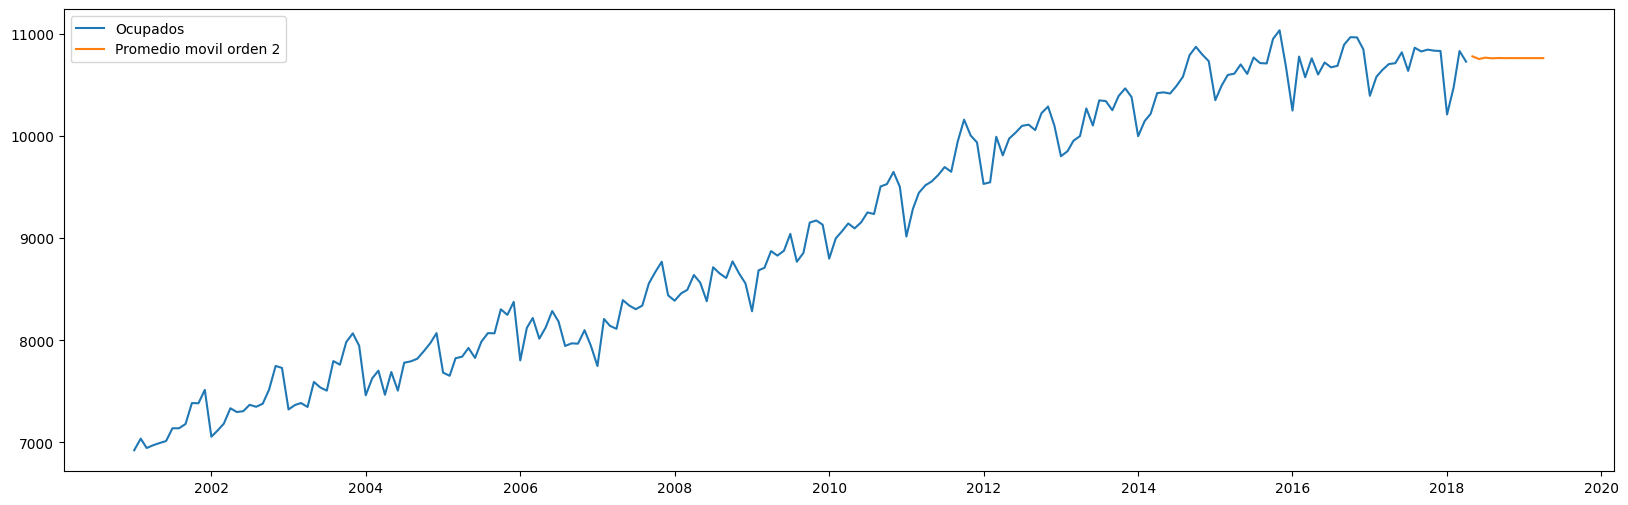

In [16]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_Ocupados,label="Ocupados")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [17]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10720.369929  10363.684215  11077.055642
2018-06-01    10720.369929  10295.289386  11145.450471
2018-07-01    10720.369929  10236.466801  11204.273056
2018-08-01    10720.369929  10184.057514  11256.682343
2018-09-01    10720.369929  10136.332451  11304.407406
2018-10-01    10720.369929  10092.223016  11348.516842
2018-11-01    10720.369929  10051.014034  11389.725823
2018-12-01    10720.369929  10012.198987  11428.540870
2019-01-01    10720.369929   9975.403586  11465.336271
2019-02-01    10720.369929   9940.341967  11500.397890
2019-03-01    10720.369929   9906.789945  11533.949912
2019-04-01    10720.369929   9874.567848  11566.172009


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


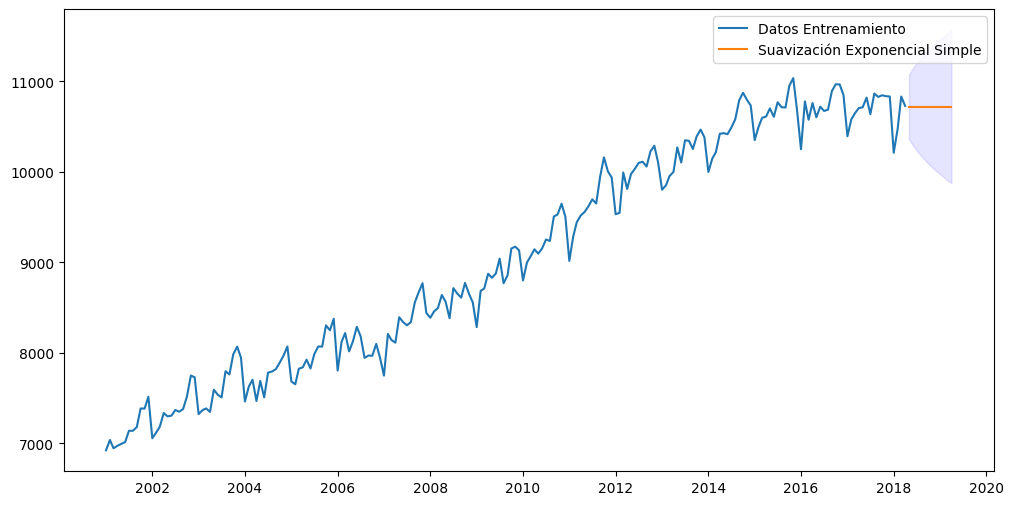

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.3596639.Y el RMSE en la muestra de evaluación es 1.12

In [19]:
ets_result.alpha

0.64828262016549

In [20]:
rmse = np.sqrt(mean_squared_error(test_Ocupados,point_forecast ))
print(rmse)

186.78626001062813


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [21]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-05-01    10749.538968  10286.227168  11149.811601
2018-06-01    10773.219074  10265.319738  11250.256718
2018-07-01    10796.951345  10246.882591  11311.539255
2018-08-01    10820.735895  10227.040210  11415.665623
2018-09-01    10844.572840  10231.787946  11437.518125
2018-10-01    10868.462295  10233.415247  11544.701084
2018-11-01    10892.404376  10170.834011  11627.387454
2018-12-01    10916.399200  10220.608929  11686.735776
2019-01-01    10940.446881  10137.326604  11750.771339
2019-02-01    10964.547537  10149.152275  11771.781643
2019-03-01    10988.701283  10122.773357  11849.019163
2019-04-01    11012.908239  10128.554578  11913.119530


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


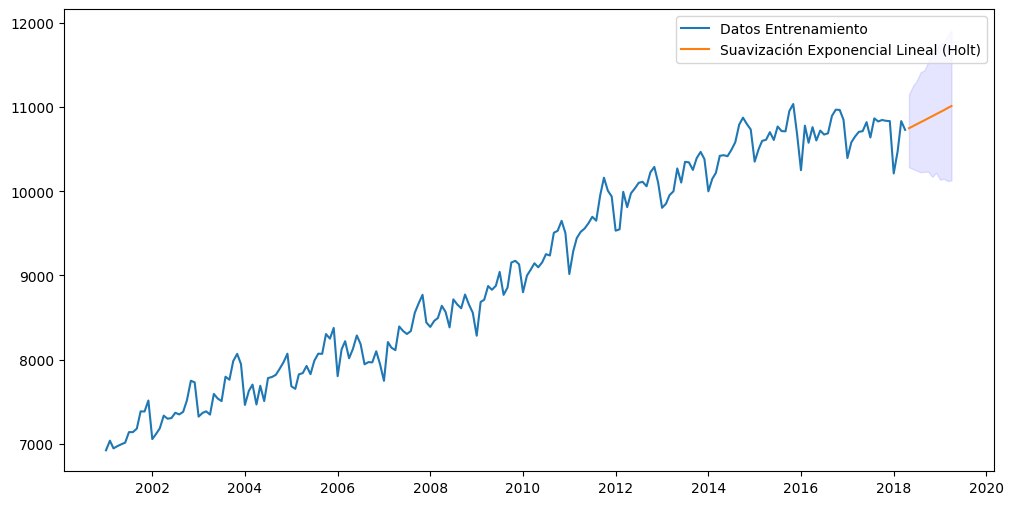

In [22]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.17153975893378887 y el β estimado es 1.7153975893378887$^{-5}$. Y el RMSE en la muestra de evaluación es 1.2780044501304348.

In [23]:
print(ets_result.alpha,ets_result.beta)

0.5619358170014888 5.619358170014888e-05


In [24]:
rmse_holt = np.sqrt(mean_squared_error(test_Ocupados,preds_holt['Point_forecast']))
print(rmse_holt)

268.0750353824623


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [25]:
# Build model
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10778.665995  10522.763977  11034.568013
2018-06-01    10842.414616  10571.475534  11113.353698
2018-07-01    10833.135392  10547.948236  11118.322547
2018-08-01    10942.078643  10643.319499  11240.837786
2018-09-01    10997.481116  10685.737756  11309.224476
2018-10-01    11095.841373  10771.630941  11420.051805
2018-11-01    11114.796671  10778.578779  11451.014563
2018-12-01    11011.833358  10664.020014  11359.646703
2019-01-01    10524.737931  10165.701220  10883.774641
2019-02-01    10802.752938  10432.831078  11172.674797
2019-03-01    10952.757611  10572.259792  11333.255430
2019-04-01    10962.102981  10571.313288  11352.892674


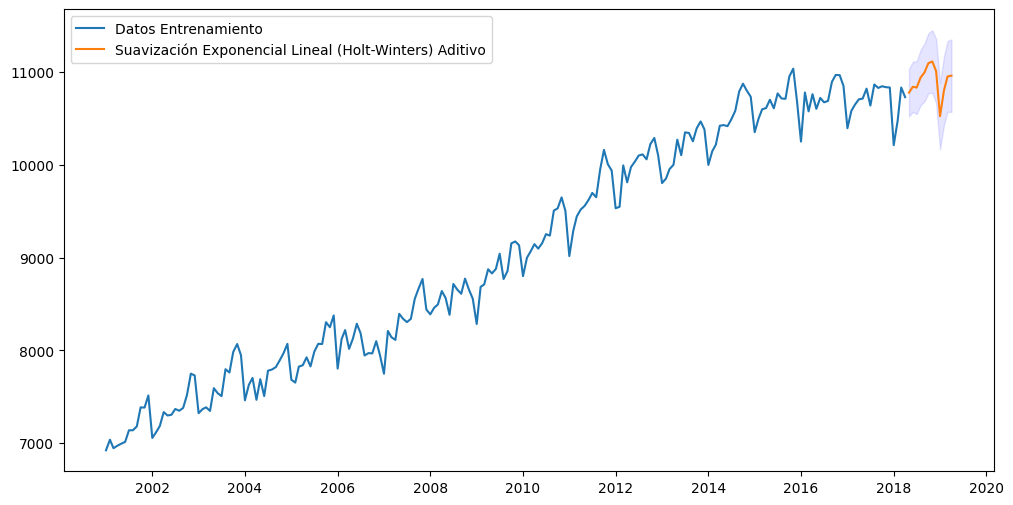

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [27]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.3477796836673897 3.477796836673897e-05 0.32233311550860627


In [28]:
rmse_hw_add = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.48504758732224


In [33]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-05-01    10787.445560  10578.227879  11017.459186
2018-06-01    10757.066048  10477.092577  11020.589196
2018-07-01    10832.086781  10517.061413  11136.035040
2018-08-01    10816.529572  10459.022623  11174.385904
2018-09-01    10878.550584  10506.356803  11255.096928
2018-10-01    11021.780881  10629.032147  11448.460659
2018-11-01    11036.623687  10608.547249  11461.035639
2018-12-01    10910.527706  10483.007627  11331.836055
2019-01-01    10434.469409   9987.036053  10876.117064
2019-02-01    10638.037581  10154.689556  11116.529432
2019-03-01    10721.751676  10223.809192  11191.683025
2019-04-01    10730.726120  10210.318621  11245.230717


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


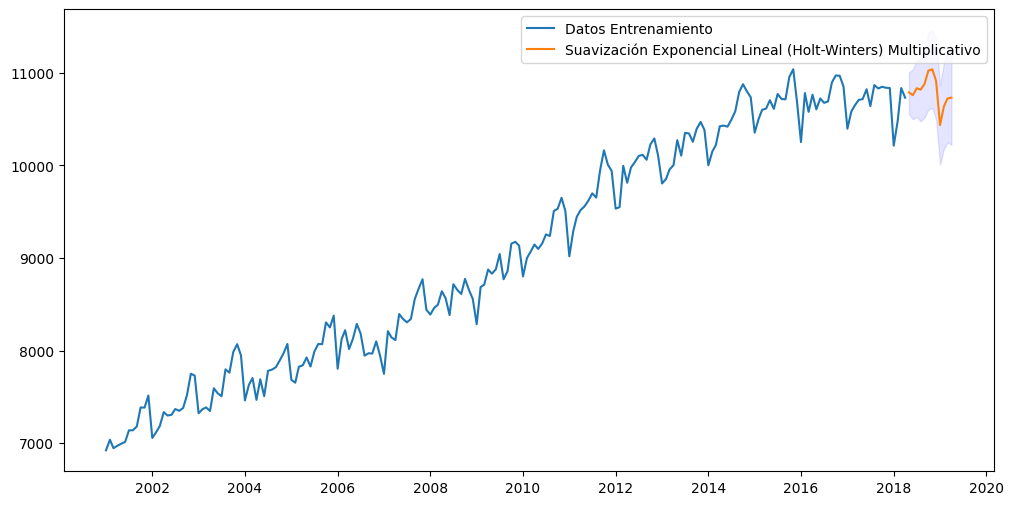

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [31]:
print(ets_result.alpha,ets_result.gamma)

0.6067551916686356 3.932448083313645e-05


In [32]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

122.3605572053717


## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [115]:
def calculo(train, tipo, i_error, i_trend, i_seasonal):
  print( "Procesando", tipo,  i_error, i_trend, i_seasonal)


  # Build model.
  if i_seasonal == "None":
    if i_trend == "None":
      ets_model = ETSModel(endog=train["Ocupados"],error=i_error)
    elif i_error == "None":
      ets_model = ETSModel(endog=train["Ocupados"],trend=i_trend)
    else:
      ets_model = ETSModel(endog=train["Ocupados"],error=i_error,trend=i_trend)
  elif i_trend == "None":
    if i_error == "None":
      ets_model = ETSModel(endog=train["Ocupados"],seasonal=i_seasonal)
    else:
      ets_model = ETSModel(endog=train["Ocupados"],error=i_error,seasonal=i_seasonal)
  elif i_error == "None":
    ets_model = ETSModel(endog=train["Ocupados"],trend=i_trend,seasonal=i_seasonal)
  else:
    ets_model = ETSModel(endog=train["Ocupados"],error=i_error,trend=i_trend,seasonal=i_seasonal)
    
  ##ets_model = ETSModel(endog=train["Ocupados"],error=i_error,trend=i_trend,seasonal=i_seasonal)
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(12)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean


  preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
  preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
  print(preds_hw_mul)

  fig = plt.figure(figsize=(12, 6))
  plt.plot(train,label="Datos Entrenamiento")
  plt.plot(preds_hw_mul['Point_forecast'],label=tipo)
  plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
  plt.legend()
  plt.show()

  e_Alpha = ''
  e_Beta  = '' 
  E_Gamma = ''
  E_Gamma + ''
  RMSE    = ''

  print("Alpha:  ", ets_result.alpha)
  e_Alpha = ets_result.alpha
  
  if i_trend != "None":
    print("Beta:  ", ets_result.beta)
    e_Beta = ets_result.beta    
  if i_seasonal != "None":
    print("Gamma: ", ets_result.gamma)
    e_Gamma = ets_result.gamma
    
  rmse_hw_mul = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_mul['Point_forecast']))
  print(rmse_hw_mul)
  return( e_Alpha, e_Beta, E_Gamma , RMSE )

IndentationError: unexpected indent (1639128862.py, line 52)

In [112]:
Array_Options = [
    ["Winters", "Add", "Add", "Add"],
    ["Winters", "Add", "Add", "Mul"],
    ["Holt", "Add", "Add", "None"],
    ["Winters", "Add", "Mul", "Add"],
    ["Winters", "Add", "Mul", "Mul"],
    ["Holt", "Add", "Mul", "None"],
    ["Winters", "Add", "None", "Add"],
    ["Winters", "Add", "None", "Mul"],
    ["Simple", "Add", "None", "None"],
    ["Winters", "Mul", "Add", "Add"],
    ["Winters", "Mul", "Add", "Mul"],
    ["Holt", "Mul", "Add", "None"],
    ["Winters", "Mul", "Mul", "Add"],
    ["Winters", "Mul", "Mul", "Mul"],
    ["Holt", "Mul", "Mul", "None"],
    ["Winters", "Mul", "None", "Add"],
    ["Winters", "Mul", "None", "Mul"],
    ["Simple", "Mul", "None", "None"],
    ["Winters", "None", "Add", "Add"],
    ["Winters", "None", "Add", "Mul"],
    ["Holt", "None", "Add", "None"],
    ["Winters", "None", "Mul", "Add"],
    ["Winters", "None", "Mul", "Mul"],
    ["Holt", "None", "Mul", "None"],
    ["Winters", "None", "None", "Add"],
    ["Winters", "None", "None", "Mul"],
    ["Winters", "Add", "Mul", "Add"],
    ["Winters", "Add", "Mul", "Mul"],
    ["Holt", "Add", "Mul", "None"],
    ["Winters", "Add", "None", "Add"],
    ["Winters", "Add", "None", "Mul"],
    ["Simple", "Add", "None", "None"],
    ["Winters", "Mul", "Add", "Add"],
    ["Winters", "Mul", "Add", "Mul"],
    ["Holt", "Mul", "Add", "None"],
    ["Winters", "Mul", "Mul", "Add"],
    ["Winters", "Mul", "Mul", "Mul"],
    ["Holt", "Mul", "Mul", "None"],
    ["Winters", "Mul", "None", "Add"],
    ["Winters", "Mul", "None", "Mul"],
    ["Simple", "Mul", "None", "None"],
    ["Winters", "None", "Add", "Add"],
    ["Winters", "None", "Add", "Mul"],
    ["Holt", "None", "Add", "None"],
    ["Winters", "None", "Mul", "Add"],
    ["Winters", "None", "Mul", "Mul"],
    ["Holt", "None", "Mul", "None"],
    ["Winters", "None", "None", "Add"],
    ["Winters", "None", "None", "Mul"]
]

Procesando Winters Add Add Add


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10778.665995  10522.763977  11034.568013
2018-06-01    10842.414616  10571.475534  11113.353698
2018-07-01    10833.135392  10547.948236  11118.322547
2018-08-01    10942.078643  10643.319499  11240.837786
2018-09-01    10997.481116  10685.737756  11309.224476
2018-10-01    11095.841373  10771.630941  11420.051805
2018-11-01    11114.796671  10778.578779  11451.014563
2018-12-01    11011.833358  10664.020014  11359.646703
2019-01-01    10524.737931  10165.701220  10883.774641
2019-02-01    10802.752938  10432.831078  11172.674797
2019-03-01    10952.757611  10572.259792  11333.255430
2019-04-01    10962.102981  10571.313288  11352.892674


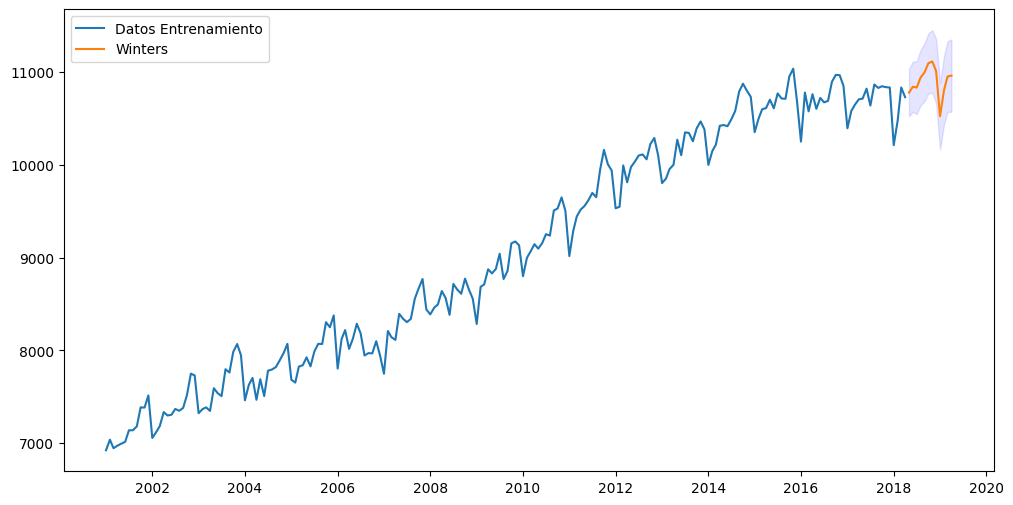

Alpha:   0.3477796836673897
Beta:   3.477796836673897e-05
Gamma:  0.32233311550860627
210.48504758732224


NameError: name 'E_Gamma' is not defined

In [113]:
for i in Array_Options:
  calculo(train_Ocupados, i[0], i[1], i[2], i[3])

In [65]:
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error='add',trend="add",seasonal='')
ets_result = ets_model.fit()
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ValueError: If not None, seasonal must be one of: 'add', 'mul', 'additive', 'multiplicative'